# ACF -- Ackerberg, Caves, Frazer -- Two-step GMM, simple version
* Uses two-step estimation, that is, first estimate $\Phi$. 
* Also makes the simplifying assumption of assuming $\omega_{it} = \rho\omega_{it-1} + \eta_{it}$
* This means there are 4 parameters to estimate; $\theta = (\beta_0, \beta_k, \beta_0, \rho)$

# Summary of the ACF method: 

Consider the "value-added" production function

$$y_{it} = \beta_0 + \beta_k k_{it} + \beta_l l_{it} + \omega_{it} + \epsilon_{it}$$

# Assumptions
* (I): Timing of Input Choices: Firms accumulate capital according to $k_{it} = \kappa\left(k_{it-1}, i_{it-1}\right)$, where investment $i_{it-1}$ is chosen in period $t-1.$ Labor input $l_{it}$ has potentially dynamic implications and is chosen at period $t$, period $t-1$, or period $t-b$ with $b\in (0, 1)$.
* (II): Scalar Unobservable: Firms' intermediate input demand is given by $m_{it} = \tilde f_t\left(k_{it}, l_{it}, \omega_{it}\right)$
* (III): Strict Monotonicity: $\tilde f_t\left(k_{it}, l_{it}, \omega_{it}\right)$ is strictly increasing in $\omega_{it}$. That is, the amount of input demanded is strictly increasing in productivity.

Note that we consider a "value-added" production function, in the sense that the intermediate input $m_{it}$ does not enter the production function to be estimated. 
* One interpretation: Gross output production function is Leontief in the intermediate input, where this intermediate input is proportional to output.

Given these assumptions, following Levinsohn and Petrin, we can invert intermediate input demand to recover the productivity: 

$$\omega_{it}= \tilde f_t^{-1}\left(k_{it}, l_{it}, m_{it}\right).$$

Then, we can substitute into the production function: 

$$
\begin{aligned}
    y_{it} & = \beta_0 + \beta_k k_{it} + \beta_l l_{it} +  f_t^{-1}\left(k_{it}, l_{it}, m_{it}\right) + \varepsilon_{it} \\
    & = \tilde \Phi_t(k_{it}, l_{it}, m_{it}) + \varepsilon_{it}
\end{aligned}
$$

ACF follow LP and treat $f_t^{-1}$ nonparametrically, so, the first three terms $\beta_0, \beta_k, \beta_l$ are not identified and subsumed into $\tilde \Phi_t(k_{it}, l_{it}, m_{it}) = \beta_0+\beta_k k_{it} + \beta_l l_{it} + \omega_{it}$, resulting in the following first-stage moment condition:

$$
E\left[\epsilon_{it} \big| \mathcal I_{it}\right] = E\left[y_{it}- \tilde \Phi_t(k_{it}, l_{it}, m_{it}) \big| \mathcal I_{it}\right]
$$

where $\mathcal I_{it-1}$ is the information set of firm $i$ at time $t-1$. 

From here, we can estimate $\hat{\tilde \Phi}_t$ nonparametrically. 

Next, we can use the second-stage conditional moment

$$
\begin{aligned}
& E[\xi_{it} + \varepsilon_{it} \big| \mathcal I_{it-1}] = \\
& E\left[y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - g\left(\hat{\tilde \Phi}_{t-1}(k_{it-1}, l_{it-1}, m_{it-1}) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\bigg| \mathcal I_{it-1}\right] = 0
\end{aligned}
$$

where the function $g(\cdot) = E[\omega_{it}|\omega_{it-1}]$ comes from:

$$
\omega_{it} = E[\omega_{it}|\mathcal I_{it-1}] + \xi_{it} = E[\omega_{it}|\omega_{it-1}]+\xi_{it} = g(\omega_{it-1}) + \xi_{it}
$$

# Identification Procedure:
For a simple example, suppose $\omega_{it} = \rho \omega_{it-1} + \xi_{it}.$ Then
$g(x) = E[x|\omega_{it-1}] = \rho \omega_{it-1}.$ Assume labor is chosen after time $t-1$. Then the estimation procedure is: 

## (1) Regress $y_{it}$ on $\left(k_{it}, l_{it}, m_{it}\right)$ nonparametrically, or using a high-order polynomial, to obtain $\hat{\tilde \Phi}_t\left(k_{it}, l_{it}, m_{it}\right).$

We do this for every period to get a sequence of functions of $(k, l, m).$ These will be plugged in for $\Phi$ in the next step. 

## (2) Use the following four moment conditions to estimate the parameters $\left(\beta_0, \beta_k, \beta_l, \rho\right):$

$$
E\left[\left(y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - \rho\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right) \otimes \begin{pmatrix} 1 \\ k_{it} \\ l_{it-1} \\ \tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) \\ \end{pmatrix} \right] = 0
$$

Here's where we use GMM. 

# Load in the data


In [136]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import math
from itertools import combinations_with_replacement, chain

In [137]:
filename = "../PS3_data_changedtoxlsx.xlsx"
cols_to_keep = [0, 2, 3, 4, 5, 6, 40, 43, 44]
#new_names = ["year", "firm_id", "obs", "ly", "s01", "s02", "lc", "ll", "lm"]
new_names = ["t", "firm_id", "obs", "y", "s01", "s02", "k", "l", "m"]
#Load in the data
df = pd.read_excel(filename, usecols=cols_to_keep)
df.columns = new_names
#Keep industry 1 only
df=df[df['s02']==1]
#Creating lagged variables
df = df.sort_values(by=['firm_id', 't'])
df['kprev'] = df.groupby('firm_id')['k'].shift(1)
df['lprev'] = df.groupby('firm_id')['l'].shift(1)
df['mprev'] = df.groupby('firm_id')['m'].shift(1)

# First step of coding: Write functions for the estimation of $\tilde \Phi_t.$

In [139]:
def poly_terms(n_features, degree):
    #This thing creates an iterator structure of tuples, used to create polynomial interaction terms. 
    #It looks something like this
    #(0,)
    #(1,)
    #(2,)
    #(0, 0)
    #(0, 1), etc 
    polynomial_terms = chain(
        *(combinations_with_replacement(range(n_features), d) for d in range(1, degree+1))
    )
    return(polynomial_terms)

def fit_phi_poly(y, xvars, degree):
    #Get number of observations (n) and number of independent variables (k)
    #y = y.to_numpy()
    #DATA = DATA.to_numpy()
    if xvars.ndim == 1:
        xvars.reshape(1, -1)
    # Get the number of samples (n) and number of features (m) from X
    n_samples, n_features = xvars.shape
    
    # Start with a column of ones for the intercept term
    X_poly = np.ones((n_samples, 1))

    #Create iterator used to construct polynomial terms
    polynomial_terms = poly_terms(n_features, degree)
    
    # Generate polynomial terms and interaction terms up to 4th degree
    for terms in  polynomial_terms:  # For degrees 1 to 4
            X_poly = np.hstack((X_poly, np.prod(xvars[:, terms], axis=1).reshape(-1, 1)))
    
    # Compute the coefficients using the normal equation: beta = (X.T * X)^(-1) * X.T * y
    XT_X = X_poly.T @ X_poly
    XT_X_inv = np.linalg.inv(XT_X)
    XT_y = X_poly.T @ y
    beta = XT_X_inv @ XT_y

    return beta

#Function to evaluate the fitted values of the polynomial regression
def eval_phi_poly(xvars, degree, beta):

    if xvars.ndim == 1:
        xvars = xvars.reshape(1, -1)
    # Get the number of samples (n) and number of features (m) from X
    n_samples, n_features = xvars.shape
    # Create polynomial terms iterator
    polynomial_terms = poly_terms(n_features, degree)

    # Start with a column of ones for the intercept term
    X_poly = np.ones((n_samples, 1))
    
    # Generate polynomial terms and interaction terms up to 4th degree
    for terms in  polynomial_terms:  # For degrees 1 to 4
            X_poly = np.hstack((X_poly, np.prod(xvars[:, terms], axis=1).reshape(-1, 1)))
    
    yhat = X_poly@beta
    
    # Generate polynomial terms and interaction terms up to 4th degree
    #yhat = np.zeros((n_samples,1))
    #for terms in  polynomial_terms:  # For degrees 1 to 4
    #        yhat = np.sum(yhat, beta*np.prod(DATA[:, terms], axis=1).reshape(-1, 1))

    return yhat

In [140]:
#Testing
xtest = np.arange(1, 13).reshape(-1, 1)
ytest = xtest**2

betatest = fit_phi_poly(ytest, xtest, 4)
yhattest = eval_phi_poly(xtest, 4, betatest)

In [141]:
degree= 3
xvars = df[['k', 'l', 'm']].to_numpy()
y = df[['y']].to_numpy()
beta = fit_phi_poly(y, xvars, degree)
yhat = eval_phi_poly(xvars, degree, beta)

## Actual by predicted plot for my polynomial approximation of $\Phi$, run on the entire sample

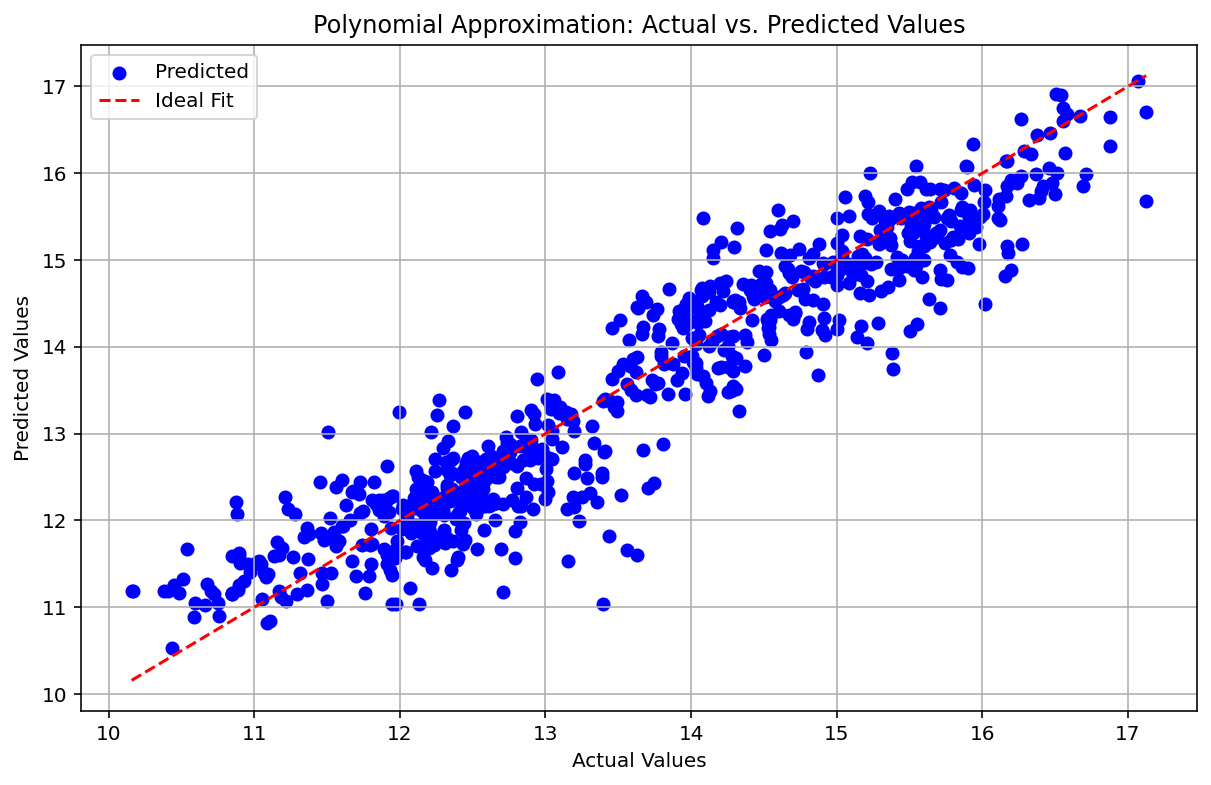

In [143]:
# Example data (replace these with your actual y and yhat values)
# Create a scatter plot for actual vs. predicted
plt.figure(figsize=(10, 6))
plt.scatter(y, yhat, color='blue', label='Predicted', marker='o')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Approximation: Actual vs. Predicted Values')
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Next step: for each time t, estimate the polynomial fit. Store in a mapping for time, k, l, m. 

## Function for evaluating the Phi function

In [146]:
def fit_phi_poly_years(df, degree):

    years = np.unique(df[["t"]])
    
    #Dictionary for storing the polynomial fits associated with each year
    phi_beta_dict = {}
    
    for t in years: 
        #Get data for the current year
        df_t = df[df["t"] == t]
        y_t = df_t[["y"]].to_numpy()
        DATA_t = df_t[['k', 'l', 'm']].to_numpy()
        #fit the polynomial
        beta_t = fit_phi_poly(y_t, DATA_t, degree)
        phi_beta_dict[t] = beta_t

    return phi_beta_dict


def phi_wrapper(row, xvars, phi_beta_dict, degree):
    DATA_row = row[xvars].to_numpy()
    t = row['t']
    beta = phi_beta_dict[t] #Get the beta fit to the particular year
    Phihat = eval_phi_poly(DATA_row, degree, beta).item()

    return Phihat

#Year-by-year --- Function to evaluate the fitted values of the polynomial regression
def eval_phi_poly_years(df, xvars, degree):
    #Year-by-year, fit the Phi function 
    phi_beta_dict = fit_phi_poly_years(df, degree)
    firms = np.unique(df[["firm_id"]])    
    df_phi = df.apply(phi_wrapper, axis = 1, args = (xvars, phi_beta_dict, degree) ).to_numpy()
    
    return df_phi

In [164]:
#phi_beta_dict = fit_phi_poly_years(df, degree)
df_phi = eval_phi_poly_years(df, xvars = ['k', 'l', 'm'], degree=2) #Higher degree than 2 and it tends to be overfit
#Add into the dataframe
df["Phi"] = df_phi
df['Phiprev'] = df.groupby('firm_id')['Phi'].shift(1)

#try this 
#df2=df.dropna()

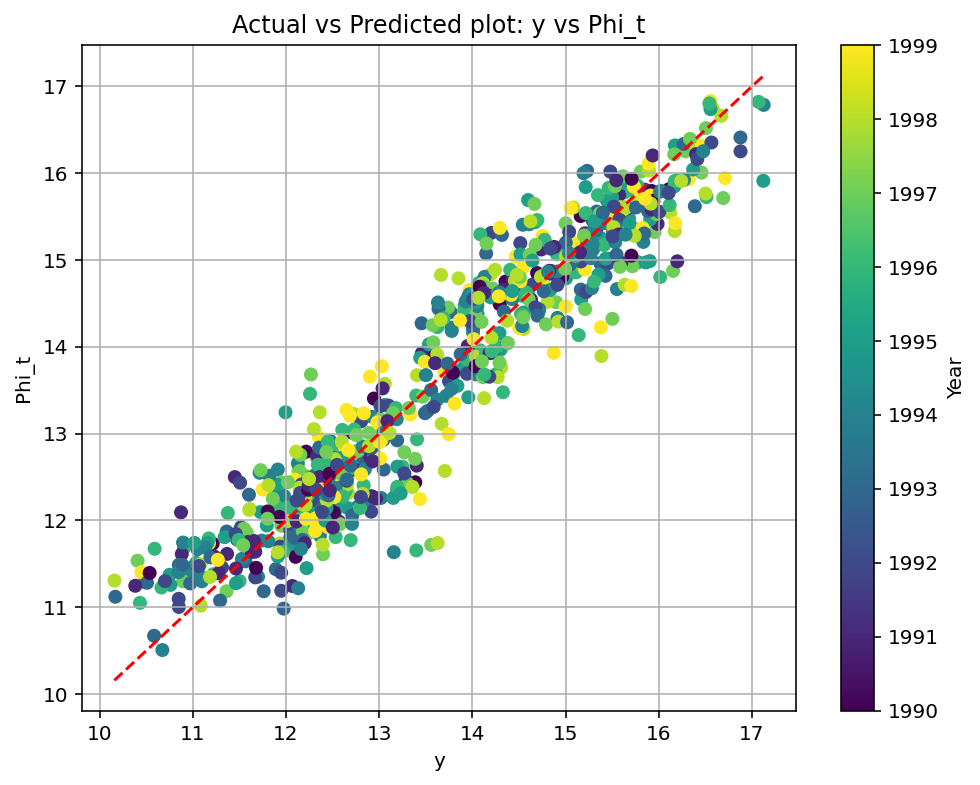

In [162]:
#Actual vs Predicted plot
# Assuming df is a structured NumPy array
actual_values = df['y']     # Extract the actual values
predicted_values = df['Phi'] # Extract the predicted values
years = df['t']

# Create the plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(actual_values, predicted_values, c=years, cmap='viridis', label='Predicted vs Actual')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')

# Add a color bar to represent the year scale
cbar = plt.colorbar(scatter)
cbar.set_label('Year')

# Add labels and title
plt.xlabel('y')
plt.ylabel('Phi_t')
plt.title('Actual vs Predicted plot: y vs Phi_t')
plt.grid(True)

# Show the plot
plt.show()

## Now, we have our polynomial fit. Time to start coding GMM
We have four parameters: $\beta_0$, $\beta_k$, $\beta_l$, and $\rho$.
Each of the four moment conditions state that 
$$E\left[\left(\xi_{it}+\epsilon_it\right)\left(Z\right)\right] = 0,$$ where $Z$ is one of the elements of the firm's information set at time $t-1.$

## Get a function that evaluates the objective function of the GMM estimator

The objective function minimizes the weighted errors of the moment restrictions with respect to parameters $\theta$. It is

$$
\min_\theta \left\{     \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)^\intercal_{1\times 4} \times\left(\mathbb W_{4\times 4}\right) \times      \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)_{4\times 1} \right\} \equiv
$$



$$
\min_\theta \left\{   \left[ \begin{pmatrix} 1^\intercal \\ \operatorname{vec}(k_{it})^\intercal \\ \operatorname{vec}(l_{it-1})^\intercal \\ \operatorname{vec}\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right)\right)^\intercal \\ \end{pmatrix} \cdot h(\theta, \mathbf y, \mathbf k, \mathbf l)\right]^\intercal_{1\times 4} \times  \left(\mathbb W_{4\times 4}\right) \times \left[ \begin{pmatrix} 1^\intercal \\ \operatorname{vec}(k_{it})^\intercal \\ \operatorname{vec}(l_{it-1})^\intercal \\ \operatorname{vec}\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right)\right)^\intercal \\ \end{pmatrix} \cdot  h(\theta, \mathbf y, \mathbf k, \mathbf l)  \right]_{4\times 1} \right\}, 
$$


which is a scalar, where

$$
h(\theta, \mathbf y, \mathbf k, \mathbf l) = \operatorname{vec}\left(y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - \rho\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right).
$$

In words, we take the dot product of the $h$ function with each of the vectors in the big pmatrix, and get four moment conditions in total. 


In [166]:
#Calculates the error term, h(theta, y, k, l)
def moment_error_ACF(theta, df):
    #get the variables we need
    #theta = [beta_0, beta_k, beta_l, rho]
    value = (df['y'] - theta[0] - theta[1]*df['k'] - theta[2]*df['l'] - 
             theta[3]*(df['Phiprev'] - theta[0] - theta[1]*df['kprev'] - theta[2]*df['lprev']) )
    #remove nans (associated with the lag) -- this is ok because we're just using this vector as part of a dot product. 
    value = np.nan_to_num(value, nan = 0)
    return value

def moment_ex_restrictions_ACF(df):
    #Moment conditions include exogeneity restrictions for 1, k_{it}, l_{it-1}, and Phi. 
    #Put them all in one matrix for easy access, called Vexc (short for vectors for exogeneity restrictions)
    #Replace all nans with zeros -- this is ok, because we're just taking a dot product over each row of this matrix, and want to remove the nans
    Vex = np.nan_to_num(np.vstack([
        np.ones(len(df['k'])), 
        df['k'], 
        df['lprev'], 
        df['Phiprev']]),  
                        nan=0)
    return Vex

def gmm_obj_ACF(theta, df, Vex, W):
    #Arguments
    #Get the vector h(theta, y, k, l)
    moment_error = moment_error_ACF(theta, df)
    #Calculate the "error" -- exogenous terms (dotproduct) h(theta, y, k, l)
    err = Vex@moment_error
    #Calculate the weighted sum of the error using the weight matrix, W
    obj = err.T@W@err
    return obj

## Quick test -- evaluating the GMM objective function at $\theta = \mathbf 1$. 

In [168]:
#Run GMM
#Initial guess for parameters beta_0, beta_k, beta_l, rho
theta0 = np.array([1,1,1,1])
#Weight matrix -- use the identity for now. 
W0 = np.eye(4)
#(2) Get matrix of variables used in exogeneity restrictions
Vex = moment_ex_restrictions_ACF(df)
#Evaluate the GMM error
obj = gmm_obj_ACF(theta0, df, Vex, W0)
obj

18804929.30596505

## Next step --  need to calculate the gradient to perform optimization. 

The gradient of the GMM objective function with respect to the parameters $\theta$ is
$$
\nabla_{\theta}  \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)^\intercal_{1\times 4} \times\left(\mathbb W_{4\times 4}\right) \times      \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)_{4\times 1} \equiv 2\left[\frac{\partial e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)}{\partial \theta}\right]^\intercal_{4\times 4}\times\left(\mathbb W_{4\times 4}\right) \times      \mathbf e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)_{4\times 1}
$$

where 

$$
\left[\frac{\partial e\left(\mathbf y, \mathbf k, \mathbf l|\theta\right)}{\partial \theta}\right]_{4\times 4} = \begin{bmatrix} 
1^\intercal\frac{ \mathbf \partial h(\theta, \mathbf y, \mathbf k, \mathbf l)}{\partial \beta_0} & 1^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)}{\partial \beta_k} & 1^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)}{\partial \beta_l} & 1^\intercal\frac{ \mathbf \partial h(\theta, \mathbf y, \mathbf k, \mathbf l)}{\partial \rho} \\
\operatorname{vec}(k_{it})^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_0} &\operatorname{vec}(k_{it})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_k} &\operatorname{vec}(k_{it})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_l} &\operatorname{vec}(k_{it})^\intercal  \frac{\partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \rho} \\
\operatorname{vec}(l_{it-1})^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_0} &\operatorname{vec}(l_{it-1})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_k} &\operatorname{vec}(l_{it-1})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_l} &\operatorname{vec}(l_{it-1})^\intercal  \frac{\partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \rho} \\
\operatorname{vec}(\Phi_{it-1})^\intercal\frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_0} &\operatorname{vec}(\Phi_{it-1})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_k} &\operatorname{vec}(\Phi_{it-1})^\intercal \frac{ \partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \beta_l} &\operatorname{vec}(\Phi_{it-1})^\intercal  \frac{\partial \mathbf h(\theta, \mathbf y, \mathbf k, \mathbf l)
}{\partial \rho} 
\end{bmatrix} 
$$

$$
\equiv \begin{bmatrix} 1^\intercal \\ \operatorname{vec}(k_{it})^\intercal \\ \operatorname{vec}(l_{it-1})^\intercal  \\ \operatorname{vec}(\Phi_{it-1})^\intercal \end{bmatrix}_{4\times n} \begin{bmatrix} \frac{\partial \mathbf h}{\partial \beta_0} & \frac{\partial \mathbf h}{\partial \beta_k} & \frac{\partial \mathbf h}{\partial \beta_l} & \frac{\partial \mathbf h}{\partial \rho}  \end{bmatrix}_{4x4}
$$


is the Jacobian of the error function with respect to $\theta = \left(\beta_0, \beta_k, \beta_l, \rho\right)$. 

We already have code to calculate the first matrix here -- it is just called ```Vex```, "vectors of exogeneity restrictions."
It remains to calculate the partial derivatives in the second matrix.

$$
\mathbf h = \operatorname{vec}\left(y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - \rho\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right)
$$

$$
\frac{\partial \mathbf h}{\partial \beta_0} =  -1 + \rho
$$
$$
\frac{\partial \mathbf h}{\partial \beta_k} = -\operatorname{vec}(k_{it}) + \rho\operatorname{vec}(k_{it-1})
$$
$$
\frac{\partial \mathbf h}{\partial \beta_l} = -\operatorname{vec}(l_{it}) + \rho\operatorname{vec}(l_{it-1})
$$
$$
\frac{\partial \mathbf h}{\partial \rho} = \operatorname{vec}\left( - \left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right) 
$$





In [170]:
def jacobian_ACF(theta, df, Vex):
    #Partial derivatives of h
    Dh = np.nan_to_num(np.vstack(
        [
         np.ones(len(df['k']))*(-1 + theta[3]), #dh/dbeta0  
         -df['k'] + theta[3]*df['kprev'],             #dh/dbetak
         -df['l'] + theta[3]*df['lprev'],             #dh/dbetal
         -(df['Phiprev'] - theta[0] - theta[1]*df['kprev'] - theta[2]*df['lprev'])
        ]
    ),  nan=0).T

    Jac = Vex@Dh
    return Jac


def gradient_ACF(theta, df, Vex, W):
    moment_error = moment_error_ACF(theta, df)
    err = Vex@moment_error
    Jac = jacobian_ACF(theta, df, Vex)
    Grad = (2*Jac.T @ W @ err)
    return Grad

In [172]:
#testing
Jac = jacobian_ACF(theta0, df, Vex)
Jac
Grad = gradient_ACF(theta0, df, Vex, W0)
Grad

array([ 0.00000000e+00,  3.92549598e+07, -2.16329950e+04, -4.52409082e+07])

## Now, use a minimization routine, with the Jacobian, to optimize for theta. 

In [176]:
gmm_args = (df, Vex, W0)

#Solving using my own gradient
theta_results_grad = opt.minimize(gmm_obj_ACF, theta0, args=gmm_args,
                       tol=1e-14, jac=gradient_ACF, method='L-BFGS-B')
#Solving without providing a gradient
#theta_results_nograd = opt.minimize(gmm_obj_ACF, theta0, args=gmm_args,
#                        tol=1e-14, method='L-BFGS-B')

theta_results_nograd = opt.minimize(gmm_obj_ACF, theta0, args=gmm_args,
                        tol=1e-14, method='Nelder-Mead', options={'maxiter': 2000})

theta_results_grad.x, theta_results_nograd.x
theta_results = theta_results_grad.x

grad = gradient_ACF(theta_results, df, Vex, W0)


print("The GMM error is:", gmm_obj_ACF(theta_results, df, Vex, W0))
print("The GMM error (no gradient) is:", gmm_obj_ACF(theta_results_nograd.x, df, Vex, W0))

print("The estimates are:", theta_results, " using gradient and ", theta_results_nograd.x, "w. no gradient")

The GMM error is: 0.04391382782759369
The GMM error (no gradient) is: 0.0500727240328267
The estimates are: [ 0.44037683  0.03454629 -2.79762032  1.00147008]  using gradient and  [ 5.31258933  0.03436371 -2.99831983  1.00163839] w. no gradient
